<a href="https://colab.research.google.com/github/AlfredoQuintellaP/CSC_4MI04/blob/main/CSC_4MI04_TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimension de l'image : 240 lignes x 360 colonnes

Méthode directe : 0.18060731 s



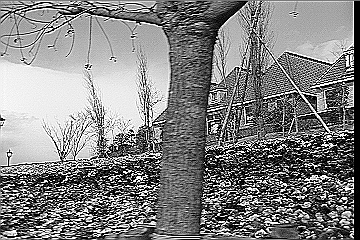


Méthode filter2D : 0.023447082 s



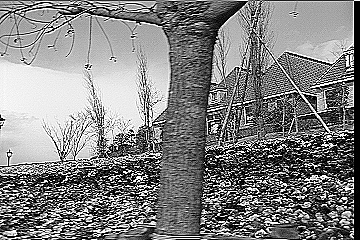

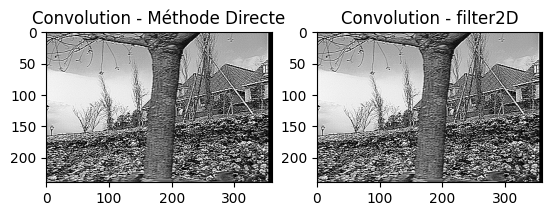

In [ ]:
# Convolutions.py code
import numpy as np
import cv2

from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow  # Importar a função específica do Colab

#from google.colab import drive
#drive.mount('/content/drive')

#Lecture image en niveau de gris et conversion en float64
img=np.float64(cv2.imread('/content/drive/MyDrive/Image_Pairs/FlowerGarden2.png',0))
(h,w) = img.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes")

#Méthode directe
t1 = cv2.getTickCount()
img2 = cv2.copyMakeBorder(img,0,0,0,0,cv2.BORDER_REPLICATE)
for y in range(1,h-1):
  for x in range(1,w-1):
    val = 5*img[y, x] - img[y-1, x] - img[y, x-1] - img[y+1, x] - img[y, x+1]
    img2[y,x] = min(max(val,0),255)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("\nMéthode directe :",time,"s\n")

cv2_imshow(img2.astype(np.uint8))
#Convention OpenCV : une image de type entier est interprétée dans {0,...,255}
cv2.waitKey(0)

plt.subplot(121)
plt.imshow(img2,cmap = 'gray')
plt.title('Convolution - Méthode Directe')

#Méthode filter2D
t1 = cv2.getTickCount()
kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
img3 = cv2.filter2D(img,-1,kernel)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("\nMéthode filter2D :",time,"s\n")

#cv2_imshow(img3/255.0)

img3_uint8 = np.clip(img3, 0, 255).astype(np.uint8)
cv2_imshow(img3_uint8)

#Convention OpenCV : une image de type flottant est interprétée dans [0,1]
cv2.waitKey(0)

plt.subplot(122)
plt.imshow(img3,cmap = 'gray',vmin = 0.0,vmax = 255.0)
#Convention Matplotlib : par défaut, normalise l'histogramme !
plt.title('Convolution - filter2D')

plt.show()

---
# Q1:
Expérimenter le code de convolution. Observer la différence entre le calcul direct et filter2d d'OpenCV. Déchiffrer les fonctions OpenCV pour lecture/copie et MatPlotLib pour affichage.

## Ans:

**Performance** : `filter2D` est significativement plus rapide (implémentation optimisée en C++ vs boucles Python)

**Traitement des bords** :
- Méthode directe : réplique les bords avec `BORDER_REPLICATE`, ne traite que la région intérieure
- `filter2D` : extrapole automatiquement les pixels pour calculer la convolution sur les bords

**Saturation des valeurs** :
- Méthode directe : sature explicitement avec `min(max(val,0),255)`
- `filter2D` : produit des valeurs float qui peuvent être en dehors de [0,255]

**Type de données** : La méthode directe convertit déjà en uint8, `filter2D` maintient float64

---
# Q2:
Expliquer pourquoi le noyau de convolution réalise un réhaussement de contraste.

## Ans:

Le noyau [[0,-1,0],[-1,5,-1],[0,-1,0]] réalise un accentuation des hautes fréquences

### Principe:

$$ Diff = 5×I - (I_{haut} + I_{bas} + I_{gauche} + I_{droite}) \\ = I + 4×(I - moyenne\_des\_voisins) $$

### Comportement selon les régions:
1. Régions uniformes (voisins ≈ pixel central): peu de changement
$$ Diff \approx 5I - 4I = I$$

2. Bords/contours (grande différence avec voisins): Renforcement du contraste
$$ Diff \approx I + 4×(I - moyenne\_voisins) $$

### Effet visuel:

- Renforce les transitions (bords deviennent plus nets)
- Accentue les détails fins
- Préserve les régions uniformes
- Augmente la perception de netteté sans modifier significativement l'histogramme global



---
# Q3:
Modifier le code pour calculer $$ Ix = \frac{\partial I}{ \partial x} \text{  et  } Iy = \frac{\partial I}{\partial y}, $$ puis $$||\nabla I|| = \sqrt{(Ix^2 + Iy^2)}.$$ Quelles précautions pour l'affichage correct (valeurs négatives et positives)?

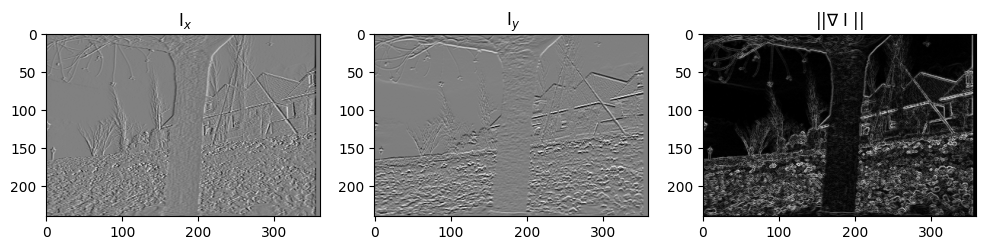

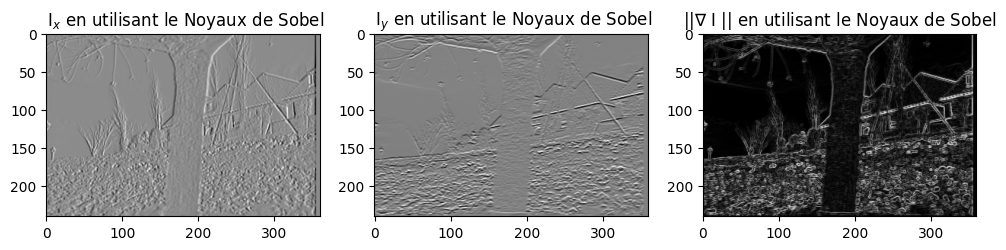

In [ ]:
# On utilise le methode le plus simple:
kernel_x = np.array([[-1, 0, 1]], dtype=np.float64)
kernel_y = np.array([[-1], [0], [1]], dtype=np.float64)

Ix = cv2.filter2D(img, cv2.CV_64F, kernel_x)
Iy = cv2.filter2D(img, cv2.CV_64F, kernel_y)

# Norme du gradient
grad_norm = np.sqrt(Ix**2 + Iy**2)

t2 = cv2.getTickCount()

# Il faut recaler les valeurs dans l'intervalle [0,255], car elles peuvent être négatives ou supérieures à 255
Ix_disp = cv2.normalize(Ix, None, 0, 255, cv2.NORM_MINMAX)
Iy_disp = cv2.normalize(Iy, None, 0, 255, cv2.NORM_MINMAX)

Ix_disp = Ix_disp.astype(np.uint8)
Iy_disp = Iy_disp.astype(np.uint8)

# Toujours positive mais peut dépasser 255
grad_disp = cv2.normalize(grad_norm, None, 0, 255, cv2.NORM_MINMAX)
grad_disp = grad_disp.astype(np.uint8)

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.imshow(Ix_disp, cmap='gray')
plt.title(r'$\text{ I}_x$')

plt.subplot(132)
plt.imshow(Iy_disp, cmap='gray')
plt.title(r'$\text{ I}_y$')

plt.subplot(133)
plt.imshow(grad_disp, cmap='gray')
plt.title(r'$||\nabla \text{ I }||$')

plt.show()


# Maintenant, on va faire avec une méthode plus robust
# Noyaux de Sobel pour le gradient
kernel_x_sobel = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]]) / 8.0

kernel_y_sobel = np.array([[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]) / 8.0

# Calcul des composantes
Ix_sobel = cv2.filter2D(img, -1, kernel_x_sobel)
Iy_sobel = cv2.filter2D(img, -1, kernel_y_sobel)

# Norme euclidienne
grad_norm_sobel = np.sqrt(Ix_sobel**2 + Iy_sobel**2)

# Il faut recaler les valeurs dans l'intervalle [0,255], car elles peuvent être négatives ou supérieures à 255
Ix_disp_sobel = cv2.normalize(Ix_sobel, None, 0, 255, cv2.NORM_MINMAX)
Iy_disp_sobel = cv2.normalize(Iy_sobel, None, 0, 255, cv2.NORM_MINMAX)

Ix_disp_sobel = Ix_disp_sobel.astype(np.uint8)
Iy_disp_sobel = Iy_disp_sobel.astype(np.uint8)

# Toujours positive mais peut dépasser 255
grad_disp_sobel = cv2.normalize(grad_norm_sobel, None, 0, 255, cv2.NORM_MINMAX)
grad_disp_sobel = grad_disp_sobel.astype(np.uint8)

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.imshow(Ix_disp_sobel, cmap='gray')
plt.title(r'$\text{ I}_x$ en utilisant le Noyaux de Sobel')

plt.subplot(132)
plt.imshow(Iy_disp_sobel, cmap='gray')
plt.title(r'$\text{ I}_y$ en utilisant le Noyaux de Sobel')

plt.subplot(133)
plt.imshow(grad_disp_sobel, cmap='gray')
plt.title(r'$||\nabla \text{ I }||$ en utilisant le Noyaux de Sobel')

plt.show()

---
# Q4:

Compléter le code fourni dans le script `Harris.py` afin de calculer la fonction d’intérêt de Harris (à une seule échelle, en utilisant une fenêtre $ W $ de taille fixe), ainsi que les points d’intérêt correspondants.  
Expliquer comment le code fourni, qui utilise la dilatation morphologique (maximum dans un voisinage donné), permet de calculer les maxima locaux de la fonction d’intérêt $ \Theta $.

## Ans


Dimension de l'image : 320 lignes x 400 colonnes
Type de l'image : float64
Mon calcul des points de Harris : 0.010432718 s
Nombre de cycles par pixel : 81.505609375 cpp
Dimension de l'image : 320 lignes x 400 colonnes x 3 canaux
Type de l'image : uint8


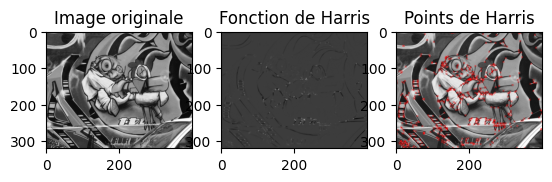

In [ ]:
# Harris.py code

import numpy as np
import cv2

from matplotlib import pyplot as plt

#Lecture image en niveau de gris et conversion en float64
img=np.float64(cv2.imread('/content/drive/MyDrive/Image_Pairs/Graffiti0.png',cv2.IMREAD_GRAYSCALE))
(h,w) = img.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes")
print("Type de l'image :",img.dtype)

#Début du calcul
t1 = cv2.getTickCount()
Theta = cv2.copyMakeBorder(img,0,0,0,0,cv2.BORDER_REPLICATE)
#########################################################
# Mettre ici le calcul de la fonction d'intérêt de Harris
#########################################################
#
# Paramètres
alpha = 0.05
window_size = 3  # taille de la fenêtre W
half_w = window_size // 2

# Dérivées
Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

# Produits des dérivées
Ix2 = Ix**2
Iy2 = Iy**2
Ixy = Ix*Iy

# Somme sur la fenêtre W (moyenne locale)
kernel = np.ones((window_size, window_size))
Sx2 = cv2.filter2D(Ix2, -1, kernel)
Sy2 = cv2.filter2D(Iy2, -1, kernel)
Sxy = cv2.filter2D(Ixy, -1, kernel)

# Fonction d'intérêt de Harris
Theta = (Sx2 * Sy2 - Sxy**2) - alpha * (Sx2 + Sy2)**2
#
#########################################################
# Calcul des maxima locaux et seuillage
Theta_maxloc = cv2.copyMakeBorder(Theta,0,0,0,0,cv2.BORDER_REPLICATE)
d_maxloc = 3
seuil_relatif = 0.01
se = np.ones((d_maxloc,d_maxloc),np.uint8)
Theta_dil = cv2.dilate(Theta,se)
#Suppression des non-maxima-locaux
Theta_maxloc[Theta < Theta_dil] = 0.0
#On néglige également les valeurs trop faibles
Theta_maxloc[Theta < seuil_relatif*Theta.max()] = 0.0
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Mon calcul des points de Harris :",time,"s")
print("Nombre de cycles par pixel :",(t2 - t1)/(h*w),"cpp")

plt.subplot(131)
plt.imshow(img,cmap = 'gray')
plt.title('Image originale')

plt.subplot(132)
plt.imshow(Theta,cmap = 'gray')
plt.title('Fonction de Harris')

se_croix = np.uint8([[1, 0, 0, 0, 1],
[0, 1, 0, 1, 0],[0, 0, 1, 0, 0],
[0, 1, 0, 1, 0],[1, 0, 0, 0, 1]])
Theta_ml_dil = cv2.dilate(Theta_maxloc,se_croix)
#Relecture image pour affichage couleur
Img_pts=cv2.imread('/content/drive/MyDrive/Image_Pairs/Graffiti0.png',cv2.IMREAD_COLOR)
(h,w,c) = Img_pts.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes x",c,"canaux")
print("Type de l'image :",Img_pts.dtype)
#On affiche les points (croix) en rouge
Img_pts[Theta_ml_dil > 0] = [255,0,0]
plt.subplot(133)
plt.imshow(Img_pts)
plt.title('Points de Harris')

plt.show()

La fonction de Harris est calculée à partir des dérivées de l’image, intégrées localement sur une fenêtre de taille fixe, ce qui permet de former la matrice d’autocorrélation $\Xi$.
La fonction d’intérêt $$ \theta = \det \Xi - \alpha \text{ trace}^2 \Xi $$ mesure les variations d’intensité dans deux directions orthogonales et prend des valeurs élevées aux coins de l’image.

Comme un coin produit une région de forte réponse, les points d’intérêt sont obtenus comme des maxima locaux de $\theta$.
La dilatation morphologique permet de calculer efficacement le maximum de $\theta$ dans un voisinage donné. La comparaison entre l’image originale et son image dilatée élimine les pixels qui ne correspondent pas à des maxima locaux.
Un seuil relatif est ensuite appliqué afin d’éliminer les réponses faibles, garantissant ainsi un unique point représentatif par coin.

---
# Q5:

Commenter les résultats obtenus avec votre détecteur de Harris et l’effet des paramètres utilisés, en particulier la taille de la fenêtre de sommation et la valeur de $\alpha$.  
Comment peut-on réaliser ce calcul sur plusieurs échelles ?  
Comment étendre la notion de maxima locaux afin de garantir que deux points d’intérêt soient toujours distants d’au moins $r$ pixels ?

## Ans

Le détecteur de Harris permet de détecter efficacement les coins et les intersections.
- Il est robuste aux faibles variations d’illumination
- Présente une faible réponse aux contours purs, ce qui est souhaitable.

En revanche,
- En l’absence d’un mécanisme approprié de suppression des non-maxima, il peut produire plusieurs points très proches les uns des autres.

La taille de la fenêtre de sommation $W$ contrôle l’intégration spatiale des dérivées. Une fenêtre de petite taille est plus sensible au bruit, mais permet de détecter des détails fins et offre une meilleure localisation des points. À l’inverse, une fenêtre plus grande produit des réponses plus stables et plus robustes au bruit, au prix d’une perte de détails fins et d’un éventuel déplacement du maximum.

Le paramètre $α$ contrôle la pénalisation de la trace de la matrice d’autocorrélation. Des valeurs faibles de $α$ conduisent à un plus grand nombre de points détectés, mais peuvent classifier des contours comme des coins, tandis que des valeurs plus élevées améliorent le rejet des contours et rendent le détecteur plus sélectif.

Pour réaliser le calcul à plusieurs échelles, on utilise un espace d’échelles obtenu par des lissages gaussiens successifs de l’image. Le détecteur de Harris est alors calculé pour chaque échelle, et les points d’intérêt sont détectés comme des maxima locaux à la fois dans le plan spatial et dans la dimension d’échelle, ce qui correspond au détecteur Harris-Laplace.

Afin de garantir que les points d’intérêt soient séparés par une distance minimale $r$, on peut étendre la suppression des non-maxima en imposant un rayon $r$ dans le voisinage considéré, ou utiliser une sélection itérative dans laquelle les points sont ordonnés selon la valeur de $Θ$ et les points les moins forts sont éliminés à l’intérieur d’un rayon $r$.

---
# Q6:

Expérimenter et comparer les deux détecteurs **ORB** et **KAZE** en lançant le script `Features_Detect.py`.  
Rappeler le principe de chacun de ces détecteurs.  
Expliquer les principaux paramètres propres à chaque détecteur et leur effet sur la détection.  
Comment peut-on évaluer visuellement la répétabilité de chaque détecteur appliqué sur une paire d’images ?

Dimension de l'image 1 : 418 lignes x 402 colonnes
Type de l'image 1 : uint8
Dimension de l'image 2 : 418 lignes x 402 colonnes
Type de l'image 2 : uint8
Détecteur : ORB
Détection des points d'intérêt : 0.004800422 s


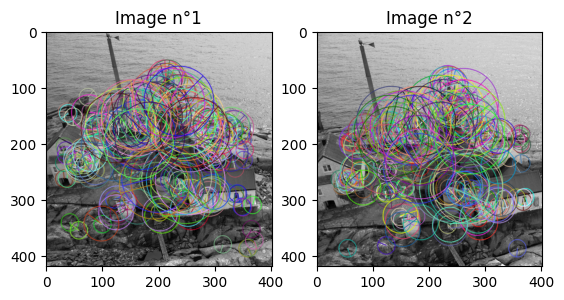

###################################################

Dimension de l'image 1 : 418 lignes x 402 colonnes
Type de l'image 1 : uint8
Dimension de l'image 2 : 418 lignes x 402 colonnes
Type de l'image 2 : uint8
Détecteur : KAZE
Détection des points d'intérêt : 0.452239309 s


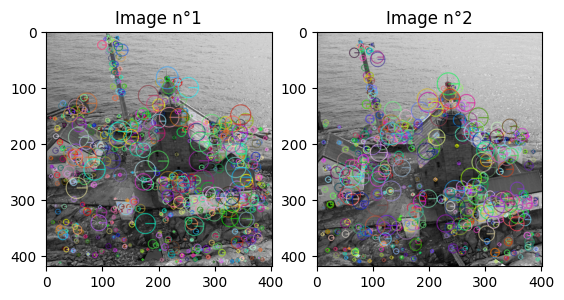

In [5]:
# Features_Detect.py com muitas modificações pro collab
import numpy as np
import cv2

from matplotlib import pyplot as plt

###############
#     ORB     #
###############

#Lecture de la paire d'images
img1 = cv2.imread('/content/drive/MyDrive/Image_Pairs/torb_small1.png')
print("Dimension de l'image 1 :",img1.shape[0],"lignes x",img1.shape[1],"colonnes")
print("Type de l'image 1 :",img1.dtype)
img2 = cv2.imread('/content/drive/MyDrive/Image_Pairs/torb_small2.png')
print("Dimension de l'image 2 :",img2.shape[0],"lignes x",img2.shape[1],"colonnes")
print("Type de l'image 2 :",img2.dtype)

#Début du calcul
t1 = cv2.getTickCount()
#Création des objets "keypoints"
kp1 = cv2.ORB_create(nfeatures = 250,#Par défaut : 500
                      scaleFactor = 2,#Par défaut : 1.2
                      nlevels = 3)#Par défaut : 8
kp2 = cv2.ORB_create(nfeatures=250,
                      scaleFactor = 2,
                      nlevels = 3)
print("Détecteur : ORB")
#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection des keypoints
pts1 = kp1.detect(gray1,None)
pts2 = kp2.detect(gray2,None)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection des points d'intérêt :",time,"s")

#Affichage des keypoints
img1 = cv2.drawKeypoints(gray1, pts1, None, flags=4)
# flags définit le niveau d'information sur les points d'intérêt
# 0 : position seule ; 4 : position + échelle + direction
img2 = cv2.drawKeypoints(gray2, pts2, None, flags=4)

plt.subplot(121)
plt.imshow(img1)
plt.title('Image n°1')

plt.subplot(122)
plt.imshow(img2)
plt.title('Image n°2')

plt.show()


################
#     KAZE     #
################
print("###################################################\n")

#Lecture de la paire d'images
img1 = cv2.imread('/content/drive/MyDrive/Image_Pairs/torb_small1.png')
print("Dimension de l'image 1 :",img1.shape[0],"lignes x",img1.shape[1],"colonnes")
print("Type de l'image 1 :",img1.dtype)
img2 = cv2.imread('/content/drive/MyDrive/Image_Pairs/torb_small2.png')
print("Dimension de l'image 2 :",img2.shape[0],"lignes x",img2.shape[1],"colonnes")
print("Type de l'image 2 :",img2.dtype)

#Début du calcul
t1 = cv2.getTickCount()


kp1 = cv2.KAZE_create(upright = False,#Par défaut : false
    		  threshold = 0.001,#Par défaut : 0.001
  		    nOctaves = 4,#Par défaut : 4
		      nOctaveLayers = 4,#Par défaut : 4
		      diffusivity = 2)#Par défaut : 2
kp2 = cv2.KAZE_create(upright = False,#Par défaut : false
	  	    threshold = 0.001,#Par défaut : 0.001
		      nOctaves = 4,#Par défaut : 4
		      nOctaveLayers = 4,#Par défaut : 4
		      diffusivity = 2)#Par défaut : 2
print("Détecteur : KAZE")



#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection des keypoints
pts1 = kp1.detect(gray1,None)
pts2 = kp2.detect(gray2,None)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection des points d'intérêt :",time,"s")

#Affichage des keypoints
img1 = cv2.drawKeypoints(gray1, pts1, None, flags=4)
# flags définit le niveau d'information sur les points d'intérêt
# 0 : position seule ; 4 : position + échelle + direction
img2 = cv2.drawKeypoints(gray2, pts2, None, flags=4)

plt.subplot(121)
plt.imshow(img1)
plt.title('Image n°1')

plt.subplot(122)
plt.imshow(img2)
plt.title('Image n°2')

plt.show()


---
# Q7:
Expliquer le principe des descripteurs attachés aux points **ORB** et ceux attachés aux points **KAZE**. Quelles propriétés des détecteurs et/ou des descripteurs (distinguer les deux aspects dans la réponse), permettent de rendre l’appariement invariant par changement d’échelles et invariant par
rotation ?

---
# Q8:
Expliquer et comparer qualitativement les performances des trois stratégies d’appariement de points d’intérêt réalisées dans les trois scripts `Features_Match_CrossCheck.py`, `Features_Match_RatioTest.py` et `Features_Match_FLANN.py`. Expliquer pourquoi les distances utilisées sont différentes pour les deux descripteurs.

---
# Q9:
Proposer une stratégie pour évaluer quantitativement la qualité des appariements en déformant une image avec une transformation géométrique connue (on pourra utiliser une fonction telle que
cv2.warpAffine).